In [74]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
from imblearn.over_sampling import SMOTE

import tools

In [97]:
DATA_DIR = '/u/13/italinv1/unix/PycharmProjects/veera-thesis/aparc_data/'
AGG = 'max'
PSD_TYPE = 'relative'
BATCH_SIZE = 128
TEST_SPLIT = 0.2
DECIM_FREQS = 'bands'
RANDOM_SEED = 42
N_EPOCHS = 8
SKIP_TRAINING = False
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.001

cases = ['%03d' % n for n in range(28)]

freq_bands = [
    (1, 4),
    (4, 8),
    (8, 10),
    (10, 13),
    (13, 30),
    (30, 40)
]

In [4]:
# get the computation device
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

## Loading data

In [382]:
class CSVDataset(Dataset):
    def __init__(self, data_dir, subject_group='both', files=None, normalize=True, decim_freqs=None, transform=None):
        self.normalize = normalize
        self.decim_freqs = decim_freqs
        self.transform = transform
        
        if files is None:
            files = glob(os.path.join(data_dir, f'*-{PSD_TYPE}-psd-fsaverage-{AGG}-aparc-data.csv'))
            
        if subject_group == 'case':
            files = [f for f in files if os.path.basename(f)[:3] in cases and 'EO' not in f]
        elif subject_group == 'control':
            files = [f for f in files if not os.path.basename(f)[:3] in cases and 'EO' not in f]
        else:
            files = [f for f in files if 'EO' not in f]
        self.files = files
        #n_files = len(files)
        #dataset_arr = []
        #for (i, file) in enumerate(files):
        #    if i % 10 == 0:
        #        print(f'processed {i}/{n_files}')
        #    df = pd.read_csv(file, delimiter=',')
        #    dataset_arr.append(df)
        #dataset = pd.concat(dataset_arr)
        #self.dataset = torch.from_numpy(dataset.values)
    
    def __len__(self): 
        #return len(self.dataset)
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        if os.path.basename(file)[:3] in cases:
            label = 1
        else:
            label = 0
        df = pd.read_csv(file, sep=',', header=None)
        data = df.values
        
        if data.shape[-1] % 2 != 0:
            data = np.insert(data, -1, data[:,-1], axis=1)
            
        if self.decim_freqs and type(self.decim_freqs) == int:
            data = data[:,::self.decim_freqs]
            
        elif type(self.decim_freqs) == str and self.decim_freqs == 'bands':
            binned_data = []
            for (lo, hi) in freq_bands:
                lo_ind, hi_ind = lo*8, hi*8
                binned_data.append(np.var(data[:,lo_ind:hi_ind], axis=1))
            data = np.asarray(binned_data).T
            
        if self.normalize:
            x_scaler = StandardScaler()
            data = x_scaler.fit_transform(data)
            
        x = torch.from_numpy(data).float()
        
        if self.transform:
            x = self.transform(x)
            
        return x, label
        #return self.dataset[i]

dataset = CSVDataset(DATA_DIR, subject_group='control', normalize=True, decim_freqs=DECIM_FREQS)
len(dataset)

641

In [385]:
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
test_size = int(TEST_SPLIT * dataset_size)
train_size = dataset_size - test_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [394]:
sampler = RandomSampler(trainset, replacement=True, num_samples=5000)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, sampler=sampler)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [395]:
len(trainloader)

40

In [396]:
# get a single batch
test_batch, test_labels = iter(trainloader).next()
test_batch.shape

torch.Size([128, 450, 6])

In [397]:
test_batch[0]

tensor([[ 0.3806, -0.1505, -0.7637, -0.5053, -0.2261, -0.9077],
        [ 1.0119,  0.3093, -0.8327, -0.4748, -0.1796, -0.7910],
        [ 0.6236, -0.0858, -0.7131, -0.3551, -0.6060, -0.9577],
        ...,
        [ 0.4267,  2.8650, -0.8313, -0.6193,  0.6132, -0.1232],
        [ 0.1239, -0.1910, -0.4119, -0.5227,  0.1189,  0.0385],
        [ 0.4518, -0.4307, -0.4818, -0.7470,  0.3305, -0.1839]])

In [398]:
test_batch[0] + 0.04 * torch.randn_like(test_batch[0])

tensor([[ 0.3247, -0.1662, -0.7471, -0.4375, -0.2132, -0.9183],
        [ 1.0634,  0.2844, -0.8812, -0.4469, -0.1677, -0.8582],
        [ 0.5894,  0.0405, -0.6553, -0.3609, -0.6363, -0.9747],
        ...,
        [ 0.4827,  2.9168, -0.8918, -0.5898,  0.6407, -0.1102],
        [ 0.0722, -0.2427, -0.4614, -0.5292,  0.0957, -0.0414],
        [ 0.4687, -0.3952, -0.4608, -0.7445,  0.3846, -0.1615]])

In [399]:
n_sources = test_batch.shape[1]
n_freqs = test_batch.shape[2]

In [400]:
cases_set = CSVDataset(DATA_DIR, subject_group='case', decim_freqs=DECIM_FREQS)
control_set = CSVDataset(DATA_DIR, subject_group='control', decim_freqs=DECIM_FREQS)
l1 = DataLoader(cases_set, batch_size=len(cases_set), shuffle=True)
l2 = DataLoader(control_set, batch_size=len(control_set), shuffle=True)
cases_batch, cases_labels = iter(l1).next()
control_batch, control_labels = iter(l2).next()
cases_batch.shape

torch.Size([25, 450, 6])

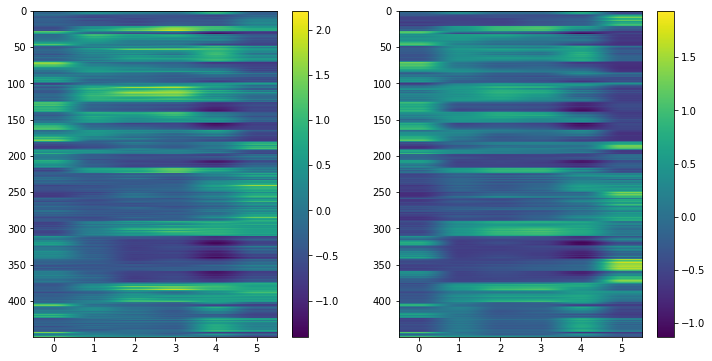

In [401]:
cases_avg = np.mean(cases_batch.detach().numpy(), axis=0)
control_avg = np.mean(control_batch.detach().numpy(), axis=0)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cases_avg, aspect='auto')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(control_avg, aspect='auto')
plt.colorbar()

## Defining the model

In [217]:
class Encoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Encoder, self).__init__()
        self.in_features = in_features
        self.fc1 = nn.Linear(in_features, 4*out_features)
        #self.fc2 = nn.Linear(4*out_features, 2*out_features)
        self.fclast = nn.Linear(4*out_features, out_features)

    def forward(self, x):
        x = x.reshape(-1, x.shape[1] * x.shape[2])
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fclast(x)
        return x

In [218]:
def test_Encoder_shapes():
    in_features = n_sources * n_freqs
    out_features = 2
    encoder = Encoder(in_features, out_features)
    
    x = torch.randn(3, n_sources, n_freqs)
    y = encoder(x)
    assert y.shape == torch.Size([3, out_features]), f"Bad y.shape: {y.shape}"
    print('Success')

test_Encoder_shapes()

Success


In [219]:
class Decoder(nn.Module):
    def __init__(self, in_features, out_features):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features, 4*in_features)
        #self.fc2 = nn.Linear(2*in_features, 4*in_features)
        self.fclast = nn.Linear(4*in_features, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fclast(x)
        x = x.reshape(-1, n_sources, n_freqs)
        return x

In [220]:
def test_Decoder_shapes():
    in_features = 2
    out_features = n_sources * n_freqs

    decoder = Decoder(in_features, out_features)
    
    x = torch.randn(3, in_features)
    z = decoder(x)
    assert z.shape == torch.Size([3, n_sources, n_freqs]), "Bad shape of z: z.shape={}".format(z.shape)
    print('Success')

test_Decoder_shapes()

Success


## Training

In [345]:
def fit(encoder, decoder, dataloader, optimizer, criterion, epoch):
    print('Training')
    encoder.train()
    decoder.train()
    running_loss = 0.0

    for i, (images, labels) in tqdm(enumerate(dataloader), total=len(dataloader)):
        optimizer.zero_grad()
        img_noisy = images + 0.2 * torch.randn_like(images)
        z = encoder(img_noisy)
        x_hat = decoder(z)
        
        loss = criterion(images, x_hat)

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader)
    print(f"Train Loss: {epoch_loss:.3f}")

    return epoch_loss

In [32]:
def validate(encoder, decoder, dataloader, criterion, epoch):
    print('Validating')
    encoder.eval()
    decoder.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for i, (images, _) in tqdm(enumerate(dataloader), total=len(dataloader)):
            z = encoder(images)
            x_hat = decoder(z)

            loss = criterion(images, x_hat)
            running_loss += loss.item()
            
    epoch_loss = running_loss / len(dataloader)
    print(f"Val Loss: {epoch_loss:.3f}")  

    return epoch_loss

In [33]:
# Training loop
def train(encoder, decoder, trainloader, testloader, optimizer, criterion):
    
    train_loss = []
    val_loss = []
    
    start = time.time()
    for epoch in range(N_EPOCHS):
        print(f"Epoch {epoch+1} of {N_EPOCHS}")
        
        train_epoch_loss = fit(encoder, decoder, trainloader, optimizer, criterion, epoch)
        val_epoch_loss = validate(encoder, decoder, testloader, criterion, epoch)
        
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        
    end = time.time()

    print(f"{(end-start)/60:.3} minutes")
    
    return encoder, decoder, train_loss, val_loss

In [402]:
# Create a deep autoencoder
n_features = 50
encoder = Encoder(n_sources * n_freqs, n_features)
encoder.to(device)

decoder = Decoder(n_features, n_sources * n_freqs)
decoder.to(device)

print(encoder)
print(decoder)

if not SKIP_TRAINING:
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    #optimizer = optim.Rprop(parameters, lr=LEARNING_RATE)
    optimizer = optim.Adam(parameters, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.MSELoss()
    encoder, decoder, train_loss, val_loss = train(encoder, decoder, trainloader, testloader, optimizer, criterion)

  0%|          | 0/40 [00:00<?, ?it/s]

Encoder(
  (fc1): Linear(in_features=2700, out_features=200, bias=True)
  (fclast): Linear(in_features=200, out_features=50, bias=True)
)
Decoder(
  (fc1): Linear(in_features=50, out_features=200, bias=True)
  (fclast): Linear(in_features=200, out_features=2700, bias=True)
)
Epoch 1 of 8
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.722
Validating


  0%|          | 0/40 [00:00<?, ?it/s]

Val Loss: 0.601
Epoch 2 of 8
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.494
Validating


  0%|          | 0/40 [00:00<?, ?it/s]

Val Loss: 0.470
Epoch 3 of 8
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.409
Validating


  0%|          | 0/40 [00:00<?, ?it/s]

Val Loss: 0.436
Epoch 4 of 8
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.366
Validating


  0%|          | 0/40 [00:00<?, ?it/s]

Val Loss: 0.412
Epoch 5 of 8
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.336
Validating


  0%|          | 0/40 [00:00<?, ?it/s]

Val Loss: 0.403
Epoch 6 of 8
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.322
Validating


  0%|          | 0/40 [00:00<?, ?it/s]

Val Loss: 0.397
Epoch 7 of 8
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.308
Validating


  0%|          | 0/40 [00:00<?, ?it/s]

Val Loss: 0.395
Epoch 8 of 8
Training


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.296
Validating


100%|██████████| 1/1 [00:04<00:00,  4.74s/it]

Val Loss: 0.395
25.5 minutes


In [96]:
if not SKIP_TRAINING:
    tools.save_model(encoder)
    tools.save_model(decoder)
else:
    encoder = Encoder(n_components=10)
    tools.load_model(encoder, device)

    decoder = Decoder(n_components=10)
    tools.load_model(decoder, device)

Type the file name to save the model to  encoder.pth


Model saved to encoder.pth.


Type the file name to save the model to  decoder.pth


Model saved to decoder.pth.


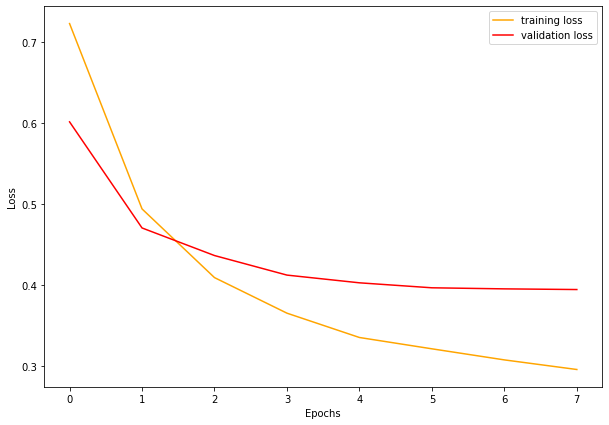

In [403]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='training loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [362]:
def get_loss_dist(dataset, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    losses = []
    labels = []
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    with torch.no_grad():
        for i, (images, labs) in enumerate(dataloader):
            z = encoder(images)
            x_hat = decoder(z)
            plt.figure(figsize=(12,6))
            plt.subplot(1,2,1)
            plt.imshow(images[0], aspect='auto')
            plt.colorbar()
            plt.subplot(1,2,2)
            plt.imshow(x_hat[0], aspect='auto')
            plt.colorbar()
            for j in range(len(images)):
                img = images[j].unsqueeze(0)
                target = x_hat[j].unsqueeze(0)
                loss = criterion(img, target)
                losses.append(torch.mean(torch.max(loss, 1)[0]).item())
                labels.append(labs[j].item())
    return losses, labels

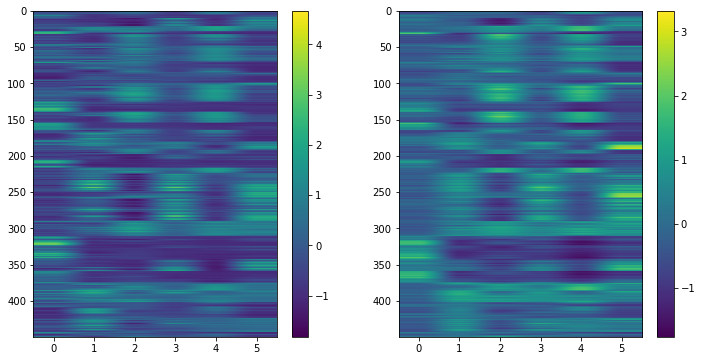

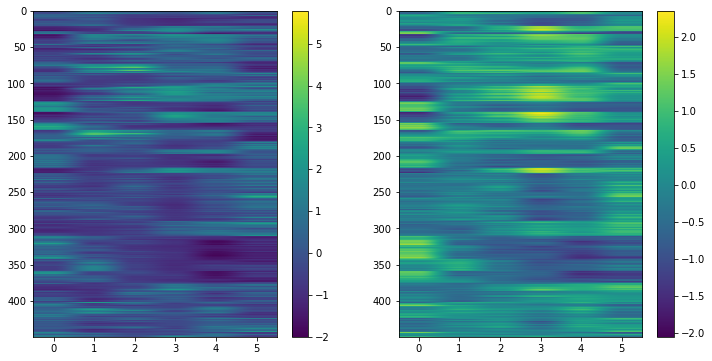

In [404]:
criterion = nn.MSELoss(reduction='none')
cases_set = CSVDataset(DATA_DIR, subject_group='case', decim_freqs=DECIM_FREQS)
loss_dist_test, labels_test = get_loss_dist(testset, encoder, decoder, criterion)
loss_dist_cases, labels_cases = get_loss_dist(cases_set, encoder, decoder, criterion)
loss_dist = loss_dist_test + loss_dist_cases
labels = labels_test + labels_cases

In [269]:
np.asarray(loss_dist).reshape(-1,1).shape

(153, 1)

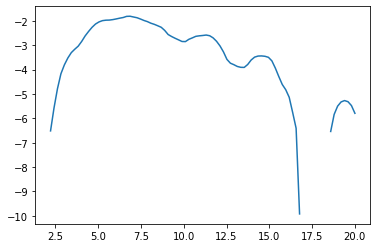

In [405]:
kde = KernelDensity(kernel='cosine', bandwidth=1)
kde.fit(np.asarray(loss_dist).reshape(-1,1))
s = np.linspace(0, 20, 100)
e = kde.score_samples(s.reshape(-1,1))
plt.plot(s, e)

In [406]:
from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

try:
    threshold = s[mi][0]
except IndexError:
    threshold = 1.6

Minima: [10.1010101  13.53535354]
Maxima: [ 6.86868687 11.31313131 14.54545455 19.39393939]


<Figure size 720x504 with 0 Axes>

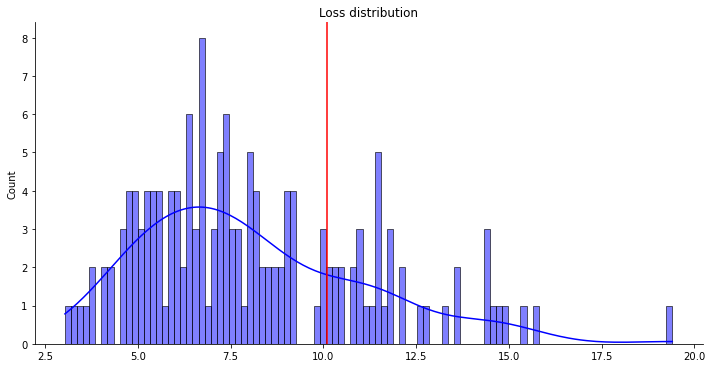

In [407]:
plt.figure(figsize=(10, 7))
sns.displot(loss_dist, bins=100, kde=True, color='blue', height=5, aspect=2)
plt.axvline(threshold, 0.0, 10, color='r')
plt.title('Loss distribution')
plt.show()

In [245]:
def print_results(loss_dist, labels, threshold):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    total_anom = 0
    
    for i in range(len(loss_dist)):
        label = labels[i]
        total_anom += label

        if loss_dist[i] >= threshold:
            if label == 1:
                tp += 1
            else:
                fp += 1
        else:
            if label == 1:
                fn += 1
            else:
                tn += 1
    print('[TP] {}\t\t[FP] {}\t\t[MISSED] {}'.format(tp, fp, total_anom-tp))
    print('[TN] {}\t[FN] {}'.format(tn, fn))

In [409]:
print_results(loss_dist, labels, 12.5)

[TP] 4		[FP] 10		[MISSED] 21
[TN] 118	[FN] 21


## Cross validation

  0%|          | 0/18 [00:00<?, ?it/s]

FOLD 1
Train set size: 548
Test set size: 96
Epoch 1 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.785
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.593
Epoch 2 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.559
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.522
Epoch 3 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.508
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.479
Epoch 4 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.468
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.451
Epoch 5 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.449
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.435
Epoch 6 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.435
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.421
Epoch 7 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.420
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.411
Epoch 8 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.412
Validating


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Val Loss: 0.403
3.15 minutes
Test set contains 3 positives out of 96


<Figure size 720x504 with 0 Axes>

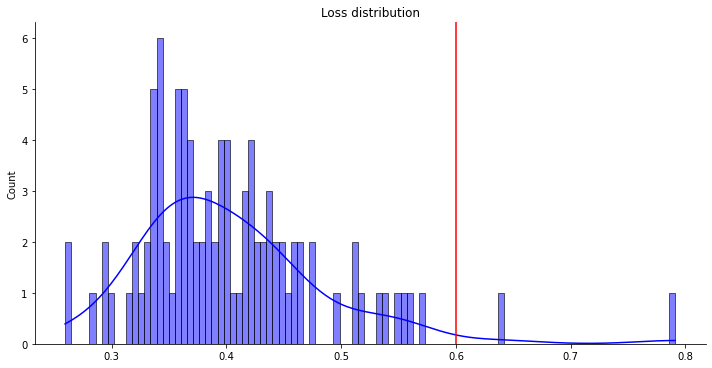

  0%|          | 0/18 [00:00<?, ?it/s]

[TP] 0		[FP] 2		[MISSED] 3
[TN] 91	[FN] 3
FOLD 2
Train set size: 550
Test set size: 95
Epoch 1 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.993
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.941
Epoch 2 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.765
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.647
Epoch 3 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.605
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.568
Epoch 4 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.536
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.516
Epoch 5 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.496
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.486
Epoch 6 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.473
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.461
Epoch 7 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.444
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.441
Epoch 8 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.430
Validating


100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


Val Loss: 0.426
3.19 minutes
Test set contains 4 positives out of 95


<Figure size 720x504 with 0 Axes>

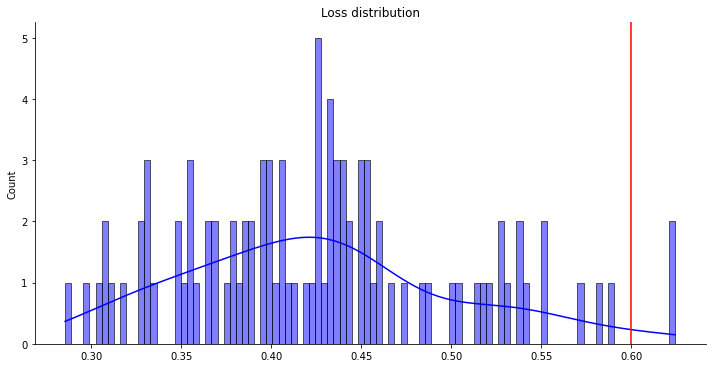

  0%|          | 0/18 [00:00<?, ?it/s]

[TP] 0		[FP] 2		[MISSED] 4
[TN] 89	[FN] 4
FOLD 3
Train set size: 548
Test set size: 95
Epoch 1 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.970
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.855
Epoch 2 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.701
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.618
Epoch 3 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.582
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.543
Epoch 4 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.519
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.495
Epoch 5 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.475
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.464
Epoch 6 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.452
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.445
Epoch 7 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.432
Validating


  0%|          | 0/18 [00:00<?, ?it/s]

Val Loss: 0.430
Epoch 8 of 8
Training


  0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.424
Validating


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Val Loss: 0.419
3.15 minutes
Test set contains 2 positives out of 95


<Figure size 720x504 with 0 Axes>

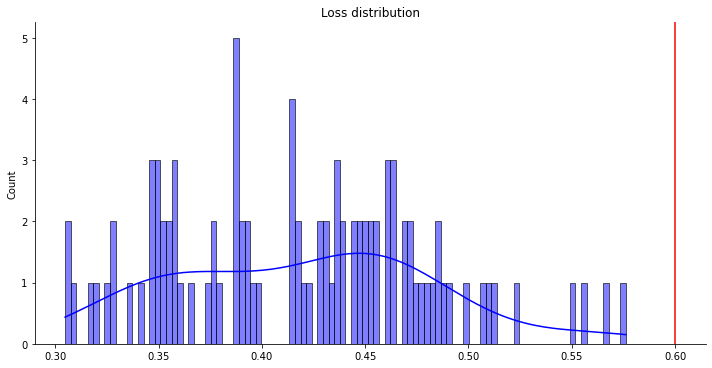

  0%|          | 0/18 [00:00<?, ?it/s]

[TP] 0		[FP] 0		[MISSED] 2
[TN] 93	[FN] 2
FOLD 4
Train set size: 550
Test set size: 95
Epoch 1 of 8
Training


 28%|██▊       | 5/18 [00:07<00:19,  1.48s/it]


KeyboardInterrupt: 

In [164]:
# Create a deep autoencoder
n_features = 20
encoder = Encoder(n_features, n_sources)
encoder.to(device)

decoder = Decoder(n_features, n_sources)
decoder.to(device)

parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Rprop(parameters, lr=LEARNING_RATE)
criterion = nn.MSELoss()

kf = KFold(n_splits=7, shuffle=True)
kde = KernelDensity(kernel='cosine', bandwidth=0.2)
s = np.linspace(0, 2, 100)

files = [f for f in glob(os.path.join(DATA_DIR, f'*-{PSD_TYPE}-psd-fsaverage-{AGG}-aparc-data.csv'))]
threshold = 0.6

for fold, (train_idx, test_idx) in enumerate(kf.split(files)):
    print('FOLD', fold+1)
    
    for model in [encoder, decoder]:
        for layer in model.children():
           if hasattr(layer, 'reset_parameters'):
               layer.reset_parameters()
                
    f_train, f_test = np.asarray(files)[train_idx], np.asarray(files)[test_idx]
    X_train = CSVDataset(DATA_DIR, subject_group='control', files=f_train, normalize=True, decim_freqs=DECIM_FREQS)
    X_test = CSVDataset(DATA_DIR, subject_group='both', files=f_test, normalize=True, decim_freqs=DECIM_FREQS)
    print("Train set size:", len(X_train))
    print("Test set size:", len(X_test))
    
    trainloader = DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True)
    testloader = DataLoader(X_test, batch_size=BATCH_SIZE, shuffle=False)
    
    encoder, decoder, train_loss, val_loss = train(encoder, decoder, trainloader, testloader, optimizer, criterion)
    
    loss_dist_test, labels_test = get_loss_dist(X_test, encoder, decoder)
    print("Test set contains", sum(labels_test), "positives out of", len(labels_test))
    plt.figure(figsize=(10, 7))
    sns.displot(loss_dist_test, bins=100, kde=True, color='blue', height=5, aspect=2)
    plt.axvline(threshold, 0.0, 10, color='r')
    plt.title('Loss distribution')
    plt.show()
    #kde.fit(np.asarray(loss_dist_test).reshape(-1,1))
    #e = kde.score_samples(s.reshape(-1,1))
    #plt.plot(s, e)
    #mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
    #threshold = s[mi][0]
    #print("Threshold loss value:", threshold)
    print_results(loss_dist_test, labels_test, threshold)